Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from matplotlib import pyplot as plt

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128
hidden_node = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weight1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_node]))
  biase1 = tf.Variable(tf.zeros([hidden_node]))
  weight2 = tf.Variable(
    tf.truncated_normal([hidden_node, num_labels]))
  biase2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, weight1) + biase1)
    logits = tf.matmul(hidden, weight2) + biase2
    return logits
  logits = model(tf_train_dataset)
  l2_loss = tf.nn.l2_loss(tf.concat([tf.reshape(weight1, [-1]), tf.reshape(weight2, [-1])], 0))
  beta = 0.001
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * l2_loss
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
    
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 697.482422
Minibatch accuracy: 5.5%
Validation accuracy: 29.5%
Minibatch loss at step 500: 201.003159
Minibatch accuracy: 85.9%
Validation accuracy: 76.2%
Minibatch loss at step 1000: 116.173790
Minibatch accuracy: 78.9%
Validation accuracy: 81.9%
Minibatch loss at step 1500: 68.660751
Minibatch accuracy: 89.1%
Validation accuracy: 83.4%
Minibatch loss at step 2000: 41.349365
Minibatch accuracy: 90.6%
Validation accuracy: 85.0%
Minibatch loss at step 2500: 25.173788
Minibatch accuracy: 88.3%
Validation accuracy: 85.6%
Minibatch loss at step 3000: 15.488243
Minibatch accuracy: 85.2%
Validation accuracy: 86.3%
Test accuracy: 93.1%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [8]:
train_dataset = train_dataset[:2000, :]
train_labels = train_labels[:2000, :]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 604.838989
Minibatch accuracy: 11.7%
Validation accuracy: 21.6%
Minibatch loss at step 500: 190.421448
Minibatch accuracy: 100.0%
Validation accuracy: 78.4%
Minibatch loss at step 1000: 115.482323
Minibatch accuracy: 100.0%
Validation accuracy: 78.2%
Minibatch loss at step 1500: 70.026505
Minibatch accuracy: 100.0%
Validation accuracy: 78.4%
Minibatch loss at step 2000: 42.463715
Minibatch accuracy: 100.0%
Validation accuracy: 78.3%
Minibatch loss at step 2500: 25.784140
Minibatch accuracy: 99.2%
Validation accuracy: 78.5%
Minibatch loss at step 3000: 15.619398
Minibatch accuracy: 100.0%
Validation accuracy: 79.2%
Test accuracy: 87.0%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [13]:
batch_size = 128
hidden_node = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weight1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_node]))
  biase1 = tf.Variable(tf.zeros([hidden_node]))
  weight2 = tf.Variable(
    tf.truncated_normal([hidden_node, num_labels]))
  biase2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  def model(data):
    hidden = tf.nn.relu(tf.matmul(data, weight1) + biase1)
    logits = tf.nn.dropout(hidden, 0.5)
    logits = tf.matmul(logits, weight2) + biase2
    return logits
  def model_test(data):
    hidden = tf.nn.relu(tf.matmul(data, weight1) + biase1)
    logits = tf.nn.dropout(hidden, 1)
    logits = tf.matmul(logits, weight2) + biase2
    return logits
  logits = model(tf_train_dataset)
  l2_loss = tf.nn.l2_loss(tf.concat([tf.reshape(weight1, [-1]), tf.reshape(weight2, [-1])], 0))
  beta = 0.001
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * l2_loss
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_test(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model_test(tf_test_dataset))
    
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 740.039917
Minibatch accuracy: 12.5%
Validation accuracy: 34.4%
Minibatch loss at step 500: 218.496384
Minibatch accuracy: 74.2%
Validation accuracy: 78.8%
Minibatch loss at step 1000: 117.875648
Minibatch accuracy: 75.0%
Validation accuracy: 80.7%
Minibatch loss at step 1500: 69.857185
Minibatch accuracy: 83.6%
Validation accuracy: 81.7%
Minibatch loss at step 2000: 41.389874
Minibatch accuracy: 87.5%
Validation accuracy: 83.6%
Minibatch loss at step 2500: 25.240374
Minibatch accuracy: 81.2%
Validation accuracy: 84.5%
Minibatch loss at step 3000: 15.467460
Minibatch accuracy: 85.2%
Validation accuracy: 85.3%
Test accuracy: 92.1%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Initialized
Minibatch loss at step 0: 2.616313
Minibatch accuracy: 13.0%
Validation accuracy: 12.8%
Minibatch loss at step 1000: 0.696674
Minibatch accuracy: 92.0%
Validation accuracy: 85.2%
Minibatch loss at step 2000: 0.778872
Minibatch accuracy: 86.5%
Validation accuracy: 86.4%
Minibatch loss at step 3000: 0.717183
Minibatch accuracy: 87.5%
Validation accuracy: 87.5%
Minibatch loss at step 4000: 0.771116
Minibatch accuracy: 87.0%
Validation accuracy: 87.8%
Minibatch loss at step 5000: 0.566869
Minibatch accuracy: 92.5%
Validation accuracy: 88.6%
Minibatch loss at step 6000: 0.600792
Minibatch accuracy: 92.0%
Validation accuracy: 89.0%
Minibatch loss at step 7000: 0.587059
Minibatch accuracy: 93.0%
Validation accuracy: 89.3%
Minibatch loss at step 8000: 0.534830
Minibatch accuracy: 92.5%
Validation accuracy: 89.5%
Minibatch loss at step 9000: 0.592006
Minibatch accuracy: 92.5%
Validation accuracy: 89.6%
Minibatch loss at step 10000: 0.527758
Minibatch accuracy: 93.5%
Validation accur

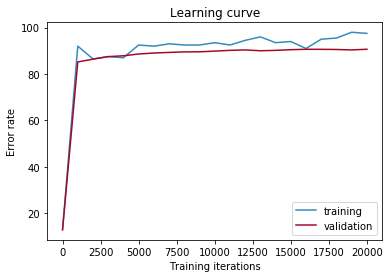

In [5]:
batch_size = 200
hidden_node = 1024

def xavier_init(fan_in, fan_out, constant=1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.float32)

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  input_weight = tf.Variable(
    xavier_init(image_size * image_size, 4 * hidden_node))
  input_bias = tf.Variable(tf.zeros([4 * hidden_node]))
  hidden_weight1 = tf.Variable(
    xavier_init(4 * hidden_node, 3 * hidden_node))
  hidden_bias1 = tf.Variable(tf.zeros([3 * hidden_node]))
  hidden_weight2 = tf.Variable(
    xavier_init(3 * hidden_node, hidden_node))
  hidden_bias2 = tf.Variable(tf.zeros([hidden_node]))
  hidden_weight3 = tf.Variable(
    xavier_init(hidden_node, num_labels))
  hidden_bias3 = tf.Variable(tf.zeros([num_labels]))
    
  # Training computation.
  def model(data):
    hidden1 = tf.nn.relu(tf.matmul(data, input_weight) + input_bias)
    dropout1 = tf.nn.dropout(hidden1, 1)
    hidden2 = tf.nn.relu(tf.matmul(dropout1, hidden_weight1) + hidden_bias1)
    dropout2 = tf.nn.dropout(hidden2, 1)
    hidden3 = tf.nn.relu(tf.matmul(dropout2, hidden_weight2) + hidden_bias2)
    dropout3 = tf.nn.dropout(hidden3, 1)
    logits = tf.matmul(dropout3, hidden_weight3) + hidden_bias3
    return logits
  def model_test(data):
    hidden1 = tf.nn.relu(tf.matmul(data, input_weight) + input_bias)
    dropout1 = tf.nn.dropout(hidden1, 1)
    hidden2 = tf.nn.relu(tf.matmul(dropout1, hidden_weight1) + hidden_bias1)
    dropout2 = tf.nn.dropout(hidden2, 1)
    hidden3 = tf.nn.relu(tf.matmul(dropout2, hidden_weight2) + hidden_bias2)
    dropout3 = tf.nn.dropout(hidden3, 1)
    logits = tf.matmul(dropout3, hidden_weight3) + hidden_bias3
    return logits
  logits = model(tf_train_dataset)
  l2_loss = tf.nn.l2_loss(tf.concat([tf.reshape(input_weight, [-1]), tf.reshape(hidden_weight1, [-1]), tf.reshape(hidden_weight2, [-1]), tf.reshape(hidden_weight3, [-1])], 0))
  beta = 0.0001
  loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta * l2_loss
  
  # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.03, global_step, 1000, 0.96)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#  optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model_test(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model_test(tf_test_dataset))
    
num_steps = 20001
train_accuracy = [0.0]
valid_accuracy = [0.0]

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      accuracy1 = accuracy(predictions, batch_labels)
      accuracy2 = accuracy(valid_prediction.eval(), valid_labels)
      train_accuracy.append(accuracy1)
      valid_accuracy.append(accuracy2)
      print("Minibatch accuracy: %.1f%%" % accuracy1)
      print("Validation accuracy: %.1f%%" % accuracy2)
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  train_plot = tf.constant(train_accuracy).eval()
  valid_plot = tf.constant(valid_accuracy).eval()
    
  # plot
  plotx = np.arange(0, num_steps, 1000)
  plt.plot(plotx, train_plot[1:], color="#348ABD", label="training")
  plt.plot(plotx, valid_plot[1:], color="#A60628", label="validation")
  plt.legend()
  plt.xlabel("Training iterations")
  plt.ylabel("Error rate")
  plt.title("Learning curve")